# Explore here

In [96]:
# Importar librerías
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

Cargar datos de exploración

In [97]:
# Cargar el archivo CSV
df = pd.read_csv("database.csv", sep=",")
pd.set_option('display.max_columns', None)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


EDA 

In [98]:
# Verificación de estructura del dataset
print(df.info())  # Muestra el tipo de datos y valores nulos
print(df.describe())  # Muestra estadísticas básicas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [99]:
# Vamos a identificar si existen valores constantes en alguna de estas columnas
n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [100]:
# Comprobar la presencia de filas duplicadas
df.duplicated().sum()

np.int64(0)

Teniendo en cuenta las columnas diponibles en esta base de datos, seleccionamos las más relevantes para conocer el mercado inmobiliario en NY como son: neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, availability_365

Por otro lado, eliminaremos las que no son necesarias como son: id, name, host_id, host_name,  last_review, calculated_host_listings_count

In [101]:
# Eliminar las columnas que no son necesarias y modificar el df directamente
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review', 'calculated_host_listings_count'], inplace=True)

In [102]:
print(df.shape)

(48895, 10)


In [103]:
# Eliminar los valores 

Análisis estadístico de los datos

In [104]:
# Cálculo de las estadísticas básicas de las columnas del df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.0,40.728949,0.054530,40.49979,40.69010,40.72307,40.763115,40.91306
longitude,48895.0,-73.952170,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
price,48895.0,152.720687,240.154170,0.00000,69.00000,106.00000,175.000000,10000.00000
minimum_nights,48895.0,7.029962,20.510550,1.00000,1.00000,3.00000,5.000000,1250.00000
number_of_reviews,48895.0,23.274466,44.550582,0.00000,1.00000,5.00000,24.000000,629.00000
reviews_per_month,38843.0,1.373221,1.680442,0.01000,0.19000,0.72000,2.020000,58.50000
availability_365,48895.0,112.781327,131.622289,0.00000,0.00000,45.00000,227.000000,365.00000


Distribución de datos

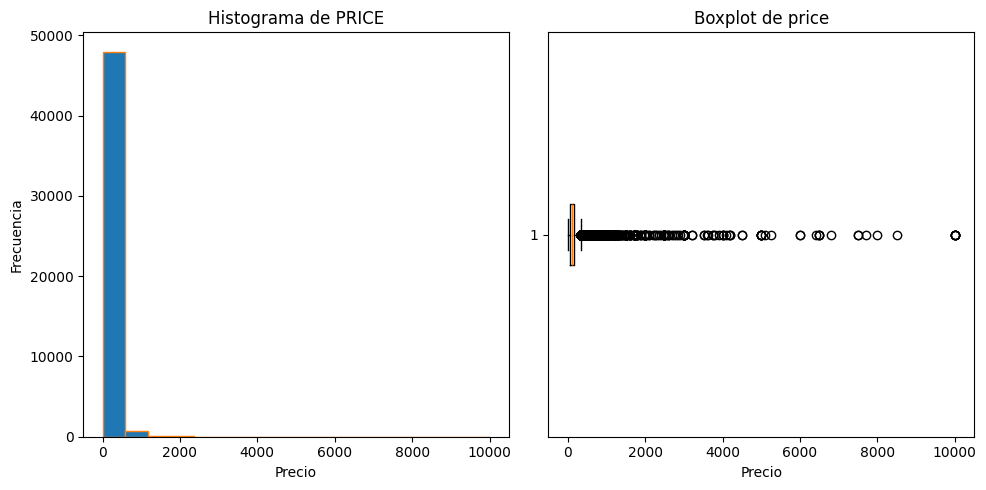

In [105]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins='sturges', color='#1f77b4', edgecolor='#ff7f0e')
ax[0].set_title('Histograma de PRICE')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de price')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

Debido a que los datos se concentran en valores inferiores a 2000, usamos la normalización de datos con el objetivo de mejorar la interpretación de los datos y reducir el ruido generado por los valores extremos.

In [106]:
# Filtrar valores problemáticos
df = df[df['price'] > 0]  # Eliminar precios 0 que generan -inf en log
df['log_price'] = np.log(df['price'])  # Aplicar logaritmo
df = df.dropna(subset=['log_price'])  # Eliminar NaN

In [107]:
print(df['log_price'].describe())

count    48884.000000
mean         4.727031
std          0.698225
min          2.302585
25%          4.234107
50%          4.663439
75%          5.164786
max          9.210340
Name: log_price, dtype: float64


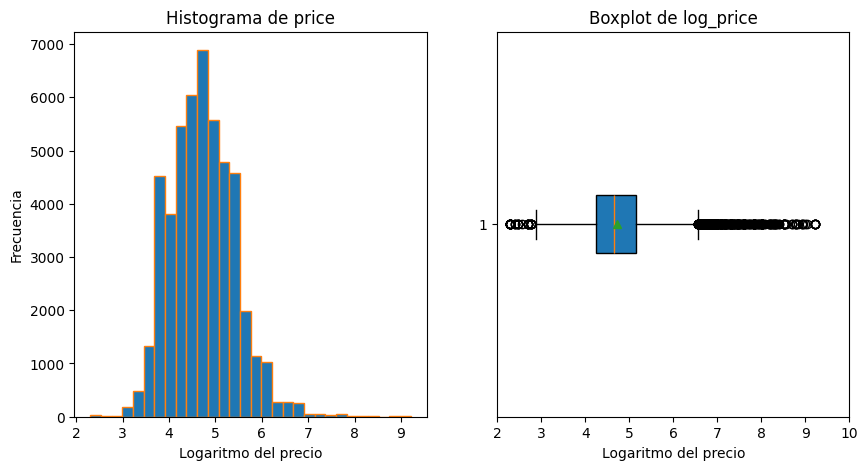

<Figure size 640x480 with 0 Axes>

In [108]:
# Crear una figura con dos subplots (uno para el histograma y otro para el boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['log_price'], bins=30, color='#1f77b4', edgecolor='#ff7f0e')
ax[0].set_title('Histograma de price')
ax[0].set_xlabel('Logaritmo del precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
plt.boxplot(df['log_price'], vert=False, patch_artist=True, showmeans=True)
plt.title("Boxplot de log_price")
plt.xlabel("Logaritmo del precio")
plt.xlim(2, 10)
plt.show()

# Mostrar la figura
plt.tight_layout()
plt.show()

Revisar los valores faltantes

In [109]:
df.isnull().mean()*100

neighbourhood_group     0.00000
neighbourhood           0.00000
latitude                0.00000
longitude               0.00000
room_type               0.00000
price                   0.00000
minimum_nights          0.00000
number_of_reviews       0.00000
reviews_per_month      20.56092
availability_365        0.00000
log_price               0.00000
dtype: float64

In [110]:
df.drop('reviews_per_month', axis=1, inplace=True)

In [111]:
# Comprobamos el porcentaje de casas que contienen valores vacíos
df.isnull().any(axis=1).sum()/len(df)*100

np.float64(0.0)

<Axes: >

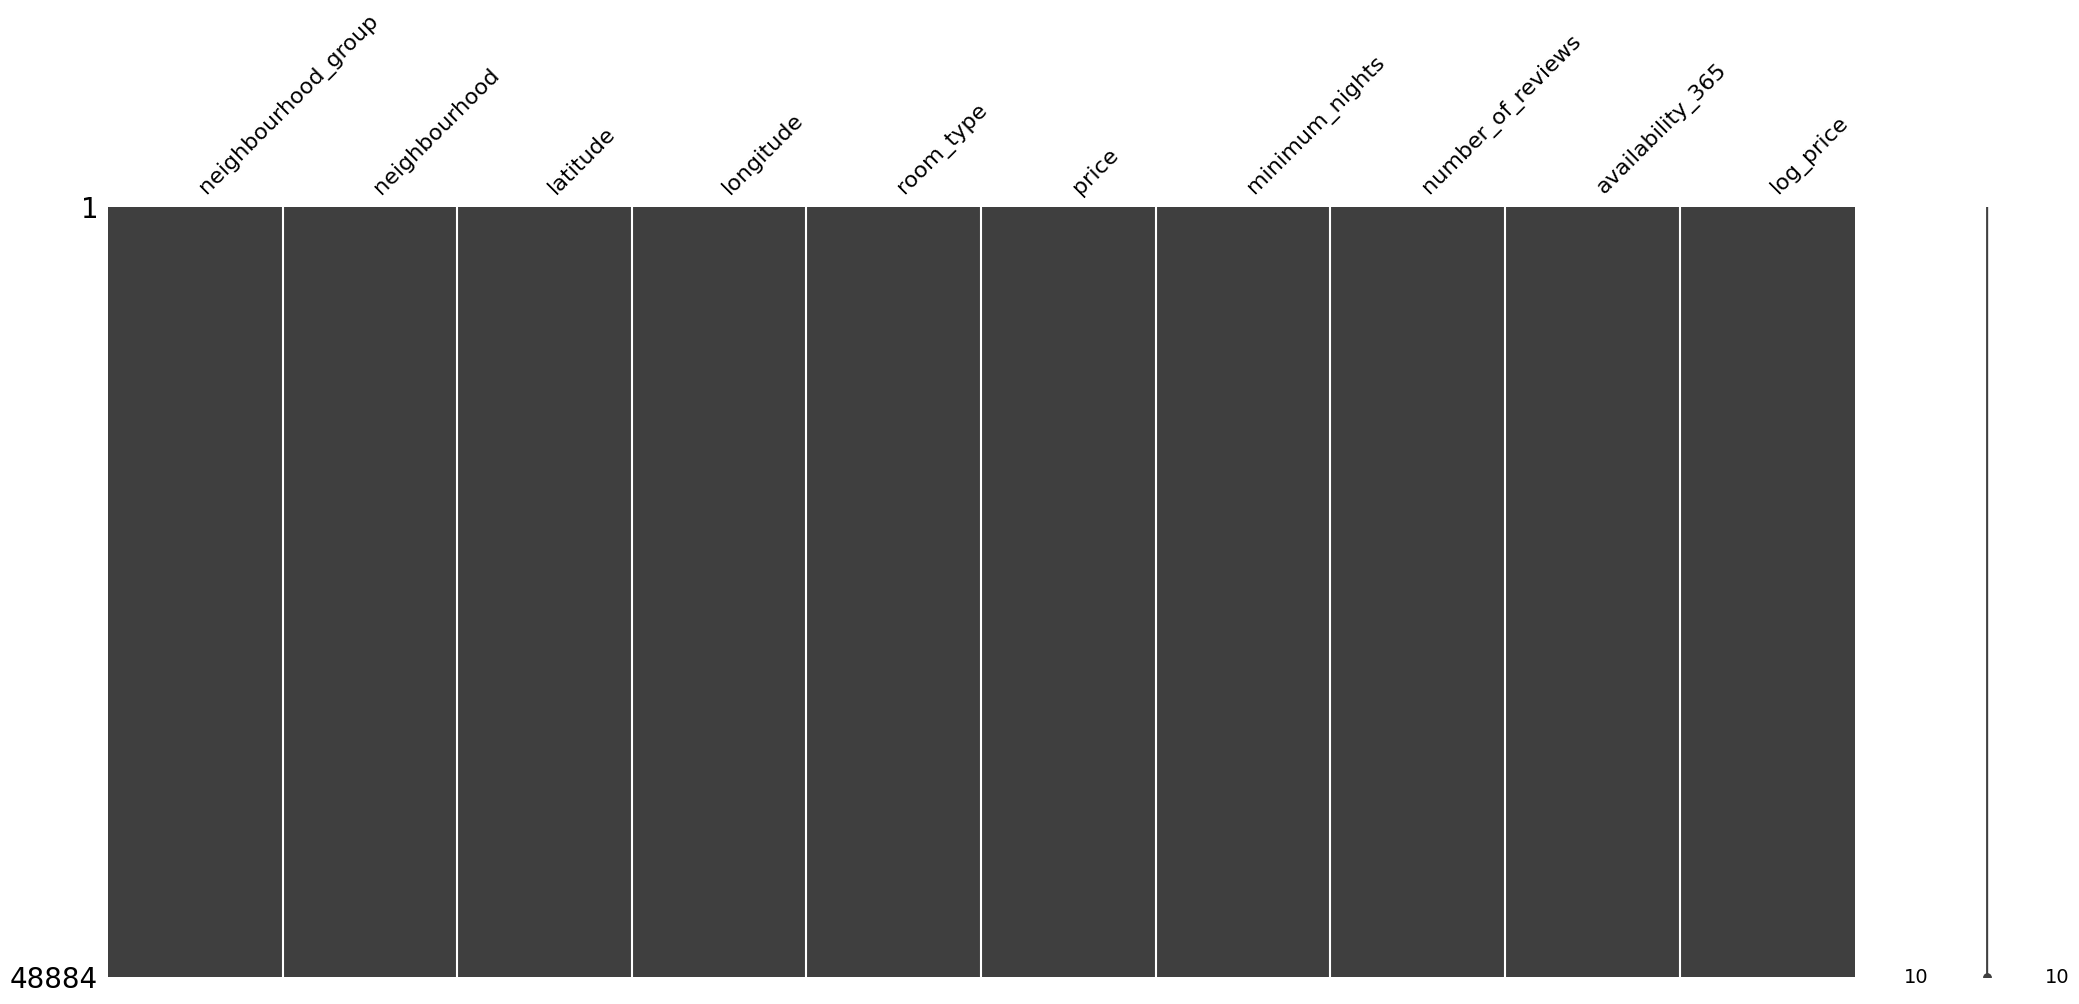

In [112]:
# Visualizamos los valores faltantes como una matriz
msno.matrix(df)

Partición de los datos

In [113]:
X = df.drop(['log_price','price'],axis=1)
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
X_train.shape

(39107, 8)

In [115]:
X_test.shape

(9777, 8)